In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/데분 부캠/관광 데이터/2024_tourism_data_utf8.csv")

In [ ]:
!pip install kmodes

In [ ]:
# 주요 방한 목적이 1. 여가, 위락, 휴식, 2. 친구, 친지 방문인 데이터만 필터링
# 근거: 1. 관광객 유치를 위한 분석임
#       2. 설문지의 응답이 방한 목적 1, 2인 사람 위주

df = df[df['Q1'].isin([1, 2])]

In [ ]:
# M일HAP 값을 카테고리로 변환
def categorize_days(days):
    if pd.isna(days):
        return None
    if days <= 3:
        return 1
    elif days <= 7:
        return 2
    elif days <= 10:
        return 3
    elif days <= 30:
        return 4
    elif days <= 60:
        return 5
    else:
        return 12

# 새로운 컬럼으로 추가
df['M일HAP_cat'] = df['M일HAP'].apply(categorize_days)

In [ ]:
# 계절 구분 함수: 3~5 봄, 6~8 여름, 9~11 가을, 12~2 겨울
def categorize_season(month):
    if pd.isna(month):
        return None
    if month in [3, 4, 5]:
        return 1  # 봄
    elif month in [6, 7, 8]:
        return 2  # 여름
    elif month in [9, 10, 11]:
        return 3  # 가을
    else:
        return 4  # 겨울

# 새로운 컬럼 생성
df['season'] = df['D_MON'].apply(categorize_season)

In [ ]:
# 사용할 컬럼 목록 정의
columns_to_keep = (
    ['Q11','M일HAP_cat', 'season', 'D_SEX', 'D_AGE'] +
    [f'Q3_1a{i}' for i in range(1, 10)]
)

# 존재하는 컬럼만 필터링 (오타 방지용)
columns_to_keep = [col for col in columns_to_keep if col in df.columns]

# 필요한 컬럼만 남기기
df = df[columns_to_keep]

In [ ]:
# 가중 무작위로 선택 (빈도가 높은 항목일수록 선택 확률 높임) - df['main_activity']

# 1. 활동 컬럼 리스트
activity_cols = ['Q3_1a1', 'Q3_1a2', 'Q3_1a3']

# 2. 결측값 채우기 및 문자열로 통일
df[activity_cols] = df[activity_cols].fillna('None').astype(str)

# 3. 전체 데이터에서 활동 빈도 계산
all_acts = df[activity_cols].values.flatten()
act_counts = Counter(a for a in all_acts if a != 'None')

# 4. 각 행에서 선택된 활동 중에서 빈도 기반 확률로 하나 무작위 선택
def weighted_pick(row):
    acts = [a for a in row if a != 'None' and a in act_counts]
    if not acts:
        return 'None'
    weights = [act_counts[a] for a in acts]
    probs = np.array(weights) / sum(weights)
    return np.random.choice(acts, p=probs)

# 5. 적용
df['main_activity'] = df[activity_cols].apply(weighted_pick, axis=1)

/tmp/ipython-input-25-4217700445.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[activity_cols] = df[activity_cols].fillna('None').astype(str)
/tmp/ipython-input-25-4217700445.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['main_activity'] = df[activity_cols].apply(weighted_pick, axis=1)


In [ ]:
# 가중 무작위

from kmodes.kmodes import KModes

# 1. 사용할 컬럼 목록
cols = ['M일HAP_cat', 'season', 'D_SEX', 'D_AGE', 'main_activity']

# 2. 데이터 준비: 문자열 형식으로 변환 + 결측값 처리
X = df[cols].fillna('None').astype(str)

# 3. k-modes 모델 정의 및 학습
km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1, random_state=42)
clusters = km.fit_predict(X)

# 4. 결과 추가
df['cluster'] = clusters

# 5. 군집별 주요 특성 보기
for i in range(4):
    print(f"\n🔹 Cluster {i} 대표 특성:")
    print(X.loc[clusters == i].mode().iloc[0])


# 빈도가 제일 높은 활동 1, 2로만 구성되어있음

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2000, cost: 27053.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1450, cost: 27261.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3017, cost: 26719.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 833, cost: 27627.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 2857, cost: 26097.0
Best run was number 5

🔹 Cluster 0 대표 특성:
M일HAP_cat          4
season             4
D_SEX              2
D_AGE              2
main_activity    2.0
Name: 0, dtype: object

🔹 Cluster 1 대표 특성:
M일HAP_cat          2
season             3
D_SEX              2
D_AGE              3
main_activity    2.0
Name: 0, dtype: object

🔹 Cluster 2 대표 특성:
M일H

/tmp/ipython-input-30-8853853.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = clusters


In [ ]:
# 무작위 선택으로 대표 활동 추출 - df['rd_activity']

# 활동 컬럼
activity_cols = ['Q3_1a1', 'Q3_1a2', 'Q3_1a3']

# NaN 제외하고 무작위 선택
def pick_random_activity(row):
    valid = [v for v in row if pd.notna(v)]
    return np.random.choice(valid) if valid else np.nan

df['rd_activity'] = df[activity_cols].apply(pick_random_activity, axis=1)


# 무작위 선택으로 추출된 활동 사용하여 군집
X = df[['M일HAP_cat', 'season', 'D_AGE', 'rd_activity']].astype(str)

km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1, random_state=42)
clusters = km.fit_predict(X)

df['rd_cluster'] = clusters

for i in range(df['rd_cluster'].nunique()):
    print(f"\n🔹 Cluster {i} 요약:")
    print(df[df['rd_cluster'] == i][['M일HAP_cat', 'season', 'D_AGE', 'rd_activity']].mode())


# 여전히 1, 2가 많음

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 906, cost: 25284.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 3326, cost: 25370.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2818, cost: 25505.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 3546, cost: 24971.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 2900, cost: 26507.0
Best run was number 4

🔹 Cluster 0 요약:
   M일HAP_cat  season  D_AGE  rd_activity
0          2       3      2          1.0

🔹 Cluster 1 요약:
   M일HAP_cat  season  D_AGE  rd_activity
0          4       2      2          1.0

🔹 Cluster 2 요약:
   M일HAP_cat  season  D_AGE  rd_activity
0          2       1      3          2.0


In [ ]:
df

,Q11,M일HAP_cat,season,D_SEX,D_AGE,Q3_1a1,Q3_1a2,Q3_1a3,rd_activity,rd_cluster,activity_cluster
0,5,2,4,2,5,1.0,2.0,NaN,1.0,0,0
1,5,2,4,2,4,11.0,2.0,1.0,11.0,0,0
2,4,2,4,2,3,12.0,5.0,2.0,2.0,2,2
3,5,2,4,1,2,11.0,2.0,6.0,6.0,0,0
4,4,2,4,2,2,1.0,NaN,NaN,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
16211,4,2,4,2,4,3.0,2.0,1.0,3.0,0,0
16212,5,2,4,1,4,12.0,3.0,1.0,12.0,0,0
16213,4,2,4,2,5,13.0,NaN,NaN,13.0,0,0
16214,5,2,4,1,5,3.0,2.0,1.0,1.0,0,0


In [ ]:
# 활동 종류 별 클러스터링

X = df['rd_activity'].values.reshape(-1,1)
km = KModes(n_clusters=3, init='Huang', n_init=20, random_state=42)
clusters = km.fit_predict(X)
df['activity_cluster'] = clusters

for i in range(df['activity_cluster'].nunique()):
    print(f"\n🔹 Cluster {i} 요약:")
    print(df[df['activity_cluster'] == i][['M일HAP_cat', 'season', 'D_AGE', 'rd_activity']].mode())


🔹 Cluster 0 요약:
   M일HAP_cat  season  D_AGE  rd_activity
0          2       2      2          1.0

🔹 Cluster 1 요약:
   M일HAP_cat  season  D_AGE  rd_activity
0          2       1      2          2.0

🔹 Cluster 2 요약:
   M일HAP_cat  season  D_AGE  rd_activity
0          2       3      2          3.0


In [ ]:
df

,Q11,M일HAP_cat,season,D_SEX,D_AGE,Q3_1a1,Q3_1a2,Q3_1a3,rd_activity,rd_cluster
0,5,2,4,2,5,1.0,2.0,NaN,1.0,0
1,5,2,4,2,4,11.0,2.0,1.0,11.0,0
2,4,2,4,2,3,12.0,5.0,2.0,2.0,2
3,5,2,4,1,2,11.0,2.0,6.0,6.0,0
4,4,2,4,2,2,1.0,NaN,NaN,1.0,0
...,...,...,...,...,...,...,...,...,...,...
16211,4,2,4,2,4,3.0,2.0,1.0,3.0,0
16212,5,2,4,1,4,12.0,3.0,1.0,12.0,0
16213,4,2,4,2,5,13.0,NaN,NaN,13.0,0
16214,5,2,4,1,5,3.0,2.0,1.0,1.0,0


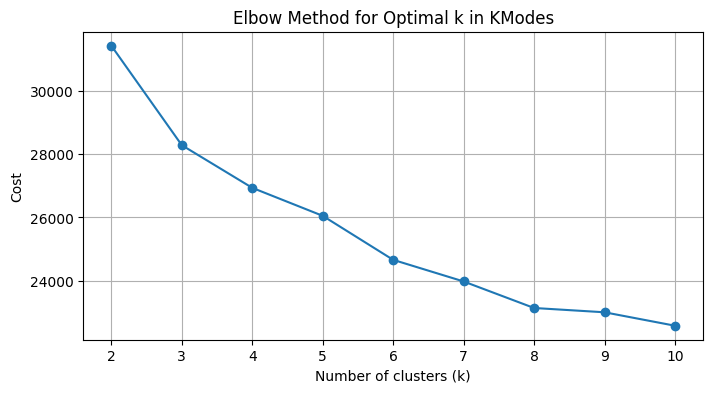

In [ ]:
import matplotlib.pyplot as plt

costs = []
K = range(2, 11)  # 군집 수 2~10까지 시도

for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42)
    km.fit(X)  # X는 원래 사용했던 데이터 (main_activity 포함한 범주형)
    costs.append(km.cost_)

# 시각화
plt.figure(figsize=(8, 4))
plt.plot(K, costs, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k in KModes')
plt.grid(True)
plt.show()

# 뚜렷한 엘보 포인트가 없음. 다른 기준이나 목적에 따라 k 선택 (급격하게 떨어지는 점인 3으로?)